In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for i in physical_devices:
    tf.config.experimental.set_memory_growth(i, True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')
classify_train_lis = []
for file in os.listdir(classify_train):
    print(os.path.join(classify_train, file))
    classify_train_lis.append(os.path.join(classify_train, file))
classify_train_lis.sort()

Classify Train Dir: /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/training
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/testing
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/validation


In [5]:
TRAINING_DIR = classify_train_lis[1]
VALIDATION_DIR = classify_train_lis[2]
TESTING_DIR = classify_train_lis[0]

In [6]:
TRAINING_DIR, VALIDATION_DIR, TESTING_DIR

('/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/training',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/validation',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/testing')

In [7]:
trainX = []
valX = []
testX = []

i,j = 0,0
for i in os.listdir(TRAINING_DIR):
    for j in os.listdir(os.path.join(TRAINING_DIR, i)):
        img = os.path.join(os.path.join(TRAINING_DIR, i), j)
        x = cv2.imread(img)
        trainX.append(x)

i,j = 0,0
for i in os.listdir(VALIDATION_DIR):
    for j in os.listdir(os.path.join(VALIDATION_DIR, i)):
        img = os.path.join(os.path.join(VALIDATION_DIR, i), j)
        x = cv2.imread(img)
        valX.append(x)
        
i,j = 0,0
for i in os.listdir(TESTING_DIR):
    for j in os.listdir(os.path.join(TESTING_DIR, i)):
        img = os.path.join(os.path.join(TESTING_DIR, i), j)
        x = cv2.imread(img)
        testX.append(x)

In [8]:
trainY = []
valY = []
testY = []

for foldername_1 in os.listdir(TRAINING_DIR):
    folder_1 = os.path.join(TRAINING_DIR, foldername_1)
    for filename in os.listdir(folder_1):
        file = os.path.join(folder_1, filename)
        
        if 'normal' in file:
            trainY.append(0)
        elif 'covid' in file:
            trainY.append(1)
            
            
for foldername_1 in os.listdir(VALIDATION_DIR):
    folder_1 = os.path.join(VALIDATION_DIR, foldername_1)
    for filename in os.listdir(folder_1):
        file = os.path.join(folder_1, filename)
        
        if 'normal' in file:
            valY.append(0)
        elif 'covid' in file:
            valY.append(1)
            
for foldername_1 in os.listdir(TESTING_DIR):
    folder_1 = os.path.join(TESTING_DIR, foldername_1)
    for filename in os.listdir(folder_1):
        file = os.path.join(folder_1, filename)
        
        if 'normal' in file:
            testY.append(0)
        elif 'covid' in file:
            testY.append(1)

In [9]:
trainX = np.array(trainX)
valX = np.array(valX)
testX = np.array(testX)

trainY = np.array(trainY)
valY = np.array(valY)
testY = np.array(testY)

In [10]:
print(trainX.shape)
print(trainY.shape)

(2128, 128, 128, 3)
(2128,)


In [11]:
print(valX.shape)
print(valY.shape)

(266, 128, 128, 3)
(266,)


In [12]:
print(testX.shape)
print(testY.shape)

(266, 128, 128, 3)
(266,)


In [13]:
trainX_norm = trainX.astype('float32')
valX_norm = valX.astype('float32')
testX_norm = testX.astype('float32')

trainX_norm = trainX_norm / 255.0
valX_norm = valX_norm / 255.0
testX_norm = testX_norm / 255.0

In [14]:
print(trainX_norm.shape)
print(valX_norm.shape)
print(testX_norm.shape)

(2128, 128, 128, 3)
(266, 128, 128, 3)
(266, 128, 128, 3)


In [15]:
trainY = to_categorical(trainY)
valY = to_categorical(valY)
testY = to_categorical(testY)

In [16]:
trainY

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
x = np.concatenate((trainX_norm, testX_norm), axis=0)
y = np.concatenate((trainY, testY), axis=0)

In [18]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.0001
Enter the maximum number of epochs: 100
Enter batch size: 8


In [19]:
char_subfolder_name = str(input("Enter name of sub-folder: "))
char_subfolder = os.path.join(classify_train_dir, char_subfolder_name)

if not os.path.exists(char_subfolder):
    os.mkdir(char_subfolder)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char_subfolder)
        os.mkdir(char_subfolder)
    else:
        pass

char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_subfolder, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        char_name = str(input("Enter name of the characteristics folder: "))
        char = os.path.join(classify_train_dir, char_subfolder, char_name)
        os.mkdir(char)

Enter name of sub-folder: 128x128
Folder already exists ! Do you want to replace it ?(Y/N) n
Enter name of the characteristics folder: 1_cv
Folder already exists ! Do you want to replace it ?(Y/N) y


In [20]:
model_name = 'model_{}.h5'.format(char_name)

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, model_name)

In [21]:
best_model_address

'/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/128x128/1_cv/model_1_cv.h5'

In [22]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 20

MONITORING TRAINING LOSS..........


Training will stop if Validation Accuracy doesn't show any improvements for 20 epcohs



In [23]:
def Custom_Model():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim))
            model.add(LeakyReLU())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(dense))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [24]:
class_no = len(os.listdir(TRAINING_DIR))

output_activation = 'softmax'
losses = 'categorical_crossentropy'
output_layer = class_no

In [25]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = keras.optimizers.SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = keras.optimizers.RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = keras.optimizers.Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = keras.optimizers.Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = keras.optimizers.Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = keras.optimizers.Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [26]:
h = int(input("Image Dimension(H or W): "))
w = h
color = int(input("Press 1 for RGB \nPress 2 for Grayscale\n"))
if color == 1:
    color_mode = 'rgb'
    dim = [h,w,3]
elif color == 2:
    color_mode = 'grayscale'
    dim = [h,w,1]

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale
1


In [27]:
dense = int(input("Enter the no. of neurons in dense layer: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

optimizer = optimizer_selection()

layer = int(input("Enter number of layers you want to apply: "))
conv_layer = int(input("Enter number of convolution layers you want to apply: "))
conv = int(input("Enter the no. of filters in the 1st convolution layer: "))
conv_size = int(input("Enter the size of filters: "))

Enter the no. of neurons in dense layer: 128
Enter the dropout percentage: 40

Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5
Enter number of layers you want to apply: 5
Enter number of convolution layers you want to apply: 1
Enter the no. of filters in the 1st convolution layer: 16
Enter the size of filters: 3


In [28]:
model = Custom_Model()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON A COMPLEX CUSTOM MODEL:-
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (M

In [29]:
n_fold = int(input("Enter number of folds: "))
print(tf.config.experimental.list_physical_devices('GPU'))
gpu_no = int(input("Which GPU ? "))

train_scores, val_scores, test_scores, histories = list(), list(), list(), list()

kfold = KFold(n_fold, shuffle=True, random_state=1)

fold_no = 1

with tf.device('/GPU:{}'.format(gpu_no)):
    for train, val in kfold.split(x, y):
        model = Custom_Model()
        model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                                       tf.keras.metrics.Precision(), 
                                                                       tf.keras.metrics.Recall(), 
                                                                       tf.keras.metrics.TruePositives(), 
                                                                       tf.keras.metrics.TrueNegatives(), 
                                                                       tf.keras.metrics.FalsePositives(),
                                                                       tf.keras.metrics.FalseNegatives()])

        print('------------------------------------------------------------------------')
        print('Training for fold {}...'.format(fold_no))

        history = model.fit(x[train], y[train], 
                            epochs=epoch, 
                            batch_size=batch_size, 
                            validation_data=(x[val], y[val]), 
                            callbacks = callback, 
                            verbose=1)

        train_score = model.evaluate(x[train], y[train])[1]
        val_score = model.evaluate(x[val], y[val])[1]
        test_score = model.evaluate(testX_norm, testY)[1]

        print("\nTraining Acc: {},\nValidation Acc: {},\nTest Acc: {}".format(train_score, val_score, test_score))

        train_scores.append(train_score)
        val_scores.append(val_score)
        test_scores.append(test_score)
        histories.append(history)

        fold_no = fold_no + 1

Enter number of folds: 10
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Which GPU ? 0

TRAINING ON A COMPLEX CUSTOM MODEL:-
------------------------------------------------------------------------
Training for fold 1...
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 13s 15ms/step - loss: 0.7109 - accuracy: 0.6155 - precision_1: 0.6155 - recall_1: 0.6155 - true_positives_1: 705.0849 - true_negatives_1: 705.0849 - false_positives_1: 382.8413 - false_negatives_1: 382.8413 - val_loss: 0.5813 - val_accuracy: 0.8208 - val_precision_1: 0.8208 - val_recall_1: 0.8208 - val_true_positives_1: 197.0000 - val_true_negatives_1: 197.0000 - val_false_positives_1: 43.0000 - val_false_negatives_1: 43.0000

Epoch 00001: loss improved from inf to 0.56976, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/128x128/1_cv/model_1_cv.h5
Epoch 2/100

Epoch 00002: Lear

270/270 [==============================] - 3s 12ms/step - loss: 0.0603 - accuracy: 0.9851 - precision_1: 0.9851 - recall_1: 0.9851 - true_positives_1: 1071.4797 - true_negatives_1: 1071.4797 - false_positives_1: 16.4465 - false_negatives_1: 16.4465 - val_loss: 0.0856 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true_negatives_1: 238.0000 - val_false_positives_1: 2.0000 - val_false_negatives_1: 2.0000

Epoch 00012: loss improved from 0.05726 to 0.05666, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/128x128/1_cv/model_1_cv.h5
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 3s 12ms/step - loss: 0.0714 - accuracy: 0.9832 - precision_1: 0.9832 - recall_1: 0.9832 - true_positives_1: 1070.2694 - true_negatives_1: 1070.2694 - false_positives_1: 17.6568 - false_negatives_1: 17.6568 - val_loss: 0.0861 - 

270/270 [==============================] - 3s 12ms/step - loss: 0.0682 - accuracy: 0.9857 - precision_1: 0.9857 - recall_1: 0.9857 - true_positives_1: 1074.2251 - true_negatives_1: 1074.2251 - false_positives_1: 13.7011 - false_negatives_1: 13.7011 - val_loss: 0.0783 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true_negatives_1: 238.0000 - val_false_positives_1: 2.0000 - val_false_negatives_1: 2.0000

Epoch 00024: loss did not improve from 0.04658
Epoch 25/100

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 12ms/step - loss: 0.0477 - accuracy: 0.9840 - precision_1: 0.9840 - recall_1: 0.9840 - true_positives_1: 1070.6827 - true_negatives_1: 1070.6827 - false_positives_1: 17.2435 - false_negatives_1: 17.2435 - val_loss: 0.0780 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true

270/270 [==============================] - 3s 12ms/step - loss: 0.0478 - accuracy: 0.9895 - precision_1: 0.9895 - recall_1: 0.9895 - true_positives_1: 1075.8155 - true_negatives_1: 1075.8155 - false_positives_1: 12.1107 - false_negatives_1: 12.1107 - val_loss: 0.0774 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true_negatives_1: 238.0000 - val_false_positives_1: 2.0000 - val_false_negatives_1: 2.0000

Epoch 00037: loss did not improve from 0.04292
Epoch 38/100

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 12ms/step - loss: 0.0481 - accuracy: 0.9831 - precision_1: 0.9831 - recall_1: 0.9831 - true_positives_1: 1069.9373 - true_negatives_1: 1069.9373 - false_positives_1: 17.9889 - false_negatives_1: 17.9889 - val_loss: 0.0774 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true

270/270 [==============================] - 3s 12ms/step - loss: 0.0515 - accuracy: 0.9838 - precision_1: 0.9838 - recall_1: 0.9838 - true_positives_1: 1069.2804 - true_negatives_1: 1069.2804 - false_positives_1: 18.6458 - false_negatives_1: 18.6458 - val_loss: 0.0774 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true_negatives_1: 238.0000 - val_false_positives_1: 2.0000 - val_false_negatives_1: 2.0000

Epoch 00050: loss did not improve from 0.04281
Epoch 51/100

Epoch 00051: LearningRateScheduler reducing learning rate to 1.0000000000000003e-09.
270/270 [==============================] - 3s 12ms/step - loss: 0.0302 - accuracy: 0.9900 - precision_1: 0.9900 - recall_1: 0.9900 - true_positives_1: 1076.7380 - true_negatives_1: 1076.7380 - false_positives_1: 11.1882 - false_negatives_1: 11.1882 - val_loss: 0.0774 - val_accuracy: 0.9917 - val_precision_1: 0.9917 - val_recall_1: 0.9917 - val_true_positives_1: 238.0000 - val_true

270/270 [==============================] - 3s 11ms/step - loss: 0.0333 - accuracy: 0.9929 - precision_2: 0.9929 - recall_2: 0.9929 - true_positives_2: 1078.4280 - true_negatives_2: 1078.4280 - false_positives_2: 9.4982 - false_negatives_2: 9.4982 - val_loss: 0.0391 - val_accuracy: 0.9792 - val_precision_2: 0.9792 - val_recall_2: 0.9792 - val_true_positives_2: 235.0000 - val_true_negatives_2: 235.0000 - val_false_positives_2: 5.0000 - val_false_negatives_2: 5.0000

Epoch 00009: loss did not improve from 0.04281
Epoch 10/100

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 3s 11ms/step - loss: 0.0388 - accuracy: 0.9886 - precision_2: 0.9886 - recall_2: 0.9886 - true_positives_2: 1075.2731 - true_negatives_2: 1075.2731 - false_positives_2: 12.6531 - false_negatives_2: 12.6531 - val_loss: 0.0285 - val_accuracy: 0.9875 - val_precision_2: 0.9875 - val_recall_2: 0.9875 - val_true_positives_2: 237.0000 - val_true_negatives_2: 237.

270/270 [==============================] - 3s 11ms/step - loss: 0.0345 - accuracy: 0.9902 - precision_2: 0.9902 - recall_2: 0.9902 - true_positives_2: 1078.6421 - true_negatives_2: 1078.6421 - false_positives_2: 9.2841 - false_negatives_2: 9.2841 - val_loss: 0.0284 - val_accuracy: 0.9833 - val_precision_2: 0.9833 - val_recall_2: 0.9833 - val_true_positives_2: 236.0000 - val_true_negatives_2: 236.0000 - val_false_positives_2: 4.0000 - val_false_negatives_2: 4.0000

Epoch 00021: loss did not improve from 0.02631
Epoch 22/100

Epoch 00022: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 11ms/step - loss: 0.0259 - accuracy: 0.9938 - precision_2: 0.9938 - recall_2: 0.9938 - true_positives_2: 1081.6015 - true_negatives_2: 1081.6015 - false_positives_2: 6.3247 - false_negatives_2: 6.3247 - val_loss: 0.0287 - val_accuracy: 0.9792 - val_precision_2: 0.9792 - val_recall_2: 0.9792 - val_true_positives_2: 235.0000 - val_true_neg


Epoch 00033: loss did not improve from 0.02265
Epoch 34/100

Epoch 00034: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 11ms/step - loss: 0.0192 - accuracy: 0.9947 - precision_2: 0.9947 - recall_2: 0.9947 - true_positives_2: 1081.0775 - true_negatives_2: 1081.0775 - false_positives_2: 6.8487 - false_negatives_2: 6.8487 - val_loss: 0.0302 - val_accuracy: 0.9792 - val_precision_2: 0.9792 - val_recall_2: 0.9792 - val_true_positives_2: 235.0000 - val_true_negatives_2: 235.0000 - val_false_positives_2: 5.0000 - val_false_negatives_2: 5.0000

Epoch 00034: loss did not improve from 0.02265
Epoch 35/100

Epoch 00035: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 11ms/step - loss: 0.0203 - accuracy: 0.9927 - precision_2: 0.9927 - recall_2: 0.9927 - true_positives_2: 1079.4576 - true_negatives_2: 1079.4576 - false_positives_2: 8.4686 - false_negatives_2

Restoring model weights from the end of the best epoch.

Epoch 00046: loss did not improve from 0.02170
Epoch 00046: early stopping
9/9 [==============================] - 0s 9ms/step - loss: 0.0473 - accuracy: 0.9887 - precision_2: 0.9887 - recall_2: 0.9887 - true_positives_2: 263.0000 - true_negatives_2: 263.0000 - false_positives_2: 3.0000 - false_negatives_2: 3.0000

Training Acc: 0.990714967250824,
Validation Acc: 0.9791666865348816,
Test Acc: 0.9887217879295349

TRAINING ON A COMPLEX CUSTOM MODEL:-
------------------------------------------------------------------------
Training for fold 3...
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 5s 14ms/step - loss: 0.6334 - accuracy: 0.6538 - precision_3: 0.6538 - recall_3: 0.6538 - true_positives_3: 769.6384 - true_negatives_3: 769.6384 - false_positives_3: 318.2878 - false_negatives_3: 318.2878 - val_loss: 0.2555 - val_accuracy: 0.9208 - val_precision_3: 0.9


Epoch 00012: loss did not improve from 0.02170
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 3s 12ms/step - loss: 0.0356 - accuracy: 0.9876 - precision_3: 0.9876 - recall_3: 0.9876 - true_positives_3: 1074.4207 - true_negatives_3: 1074.4207 - false_positives_3: 13.5055 - false_negatives_3: 13.5055 - val_loss: 0.0462 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_negatives_3: 236.0000 - val_false_positives_3: 4.0000 - val_false_negatives_3: 4.0000

Epoch 00013: loss did not improve from 0.02170
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 3s 11ms/step - loss: 0.0423 - accuracy: 0.9893 - precision_3: 0.9893 - recall_3: 0.9893 - true_positives_3: 1077.7343 - true_negatives_3: 1077.7343 - false_positives_3: 10.1919 - false_negatives_3: 10.1919 - val_loss: 0.0483 - 

270/270 [==============================] - 3s 12ms/step - loss: 0.0320 - accuracy: 0.9908 - precision_3: 0.9908 - recall_3: 0.9908 - true_positives_3: 1078.4096 - true_negatives_3: 1078.4096 - false_positives_3: 9.5166 - false_negatives_3: 9.5166 - val_loss: 0.0444 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_negatives_3: 236.0000 - val_false_positives_3: 4.0000 - val_false_negatives_3: 4.0000

Epoch 00026: loss did not improve from 0.02170
Epoch 27/100

Epoch 00027: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 12ms/step - loss: 0.0193 - accuracy: 0.9958 - precision_3: 0.9958 - recall_3: 0.9958 - true_positives_3: 1081.7196 - true_negatives_3: 1081.7196 - false_positives_3: 6.2066 - false_negatives_3: 6.2066 - val_loss: 0.0440 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_neg

270/270 [==============================] - 3s 12ms/step - loss: 0.0212 - accuracy: 0.9949 - precision_3: 0.9949 - recall_3: 0.9949 - true_positives_3: 1080.3026 - true_negatives_3: 1080.3026 - false_positives_3: 7.6236 - false_negatives_3: 7.6236 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_negatives_3: 236.0000 - val_false_positives_3: 4.0000 - val_false_negatives_3: 4.0000

Epoch 00039: loss did not improve from 0.02170
Epoch 40/100

Epoch 00040: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 12ms/step - loss: 0.0412 - accuracy: 0.9869 - precision_3: 0.9869 - recall_3: 0.9869 - true_positives_3: 1076.5018 - true_negatives_3: 1076.5018 - false_positives_3: 11.4244 - false_negatives_3: 11.4244 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_n

270/270 [==============================] - 3s 12ms/step - loss: 0.0305 - accuracy: 0.9904 - precision_3: 0.9904 - recall_3: 0.9904 - true_positives_3: 1077.4317 - true_negatives_3: 1077.4317 - false_positives_3: 10.4945 - false_negatives_3: 10.4945 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_negatives_3: 236.0000 - val_false_positives_3: 4.0000 - val_false_negatives_3: 4.0000

Epoch 00052: loss did not improve from 0.02170
Epoch 53/100

Epoch 00053: LearningRateScheduler reducing learning rate to 1.0000000000000003e-09.
270/270 [==============================] - 3s 13ms/step - loss: 0.0334 - accuracy: 0.9892 - precision_3: 0.9892 - recall_3: 0.9892 - true_positives_3: 1076.2140 - true_negatives_3: 1076.2140 - false_positives_3: 11.7122 - false_negatives_3: 11.7122 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true

270/270 [==============================] - 3s 12ms/step - loss: 0.0242 - accuracy: 0.9930 - precision_3: 0.9930 - recall_3: 0.9930 - true_positives_3: 1078.5793 - true_negatives_3: 1078.5793 - false_positives_3: 9.3469 - false_negatives_3: 9.3469 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_negatives_3: 236.0000 - val_false_positives_3: 4.0000 - val_false_negatives_3: 4.0000

Epoch 00065: loss did not improve from 0.02170
Epoch 66/100

Epoch 00066: LearningRateScheduler reducing learning rate to 1.0000000000000004e-10.
270/270 [==============================] - 3s 11ms/step - loss: 0.0241 - accuracy: 0.9960 - precision_3: 0.9960 - recall_3: 0.9960 - true_positives_3: 1082.9077 - true_negatives_3: 1082.9077 - false_positives_3: 5.0185 - false_negatives_3: 5.0185 - val_loss: 0.0430 - val_accuracy: 0.9833 - val_precision_3: 0.9833 - val_recall_3: 0.9833 - val_true_positives_3: 236.0000 - val_true_neg

270/270 [==============================] - 3s 10ms/step - loss: 0.0346 - accuracy: 0.9919 - precision_4: 0.9919 - recall_4: 0.9919 - true_positives_4: 1078.7417 - true_negatives_4: 1078.7417 - false_positives_4: 9.1845 - false_negatives_4: 9.1845 - val_loss: 0.0547 - val_accuracy: 0.9792 - val_precision_4: 0.9792 - val_recall_4: 0.9792 - val_true_positives_4: 235.0000 - val_true_negatives_4: 235.0000 - val_false_positives_4: 5.0000 - val_false_negatives_4: 5.0000

Epoch 00011: loss did not improve from 0.02170
Epoch 12/100

Epoch 00012: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 3s 12ms/step - loss: 0.0197 - accuracy: 0.9944 - precision_4: 0.9944 - recall_4: 0.9944 - true_positives_4: 1081.0037 - true_negatives_4: 1081.0037 - false_positives_4: 6.9225 - false_negatives_4: 6.9225 - val_loss: 0.0572 - val_accuracy: 0.9750 - val_precision_4: 0.9750 - val_recall_4: 0.9750 - val_true_positives_4: 234.0000 - val_true_negatives_4: 234.000


Epoch 00024: loss did not improve from 0.02170
Epoch 25/100

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 13ms/step - loss: 0.0243 - accuracy: 0.9921 - precision_4: 0.9921 - recall_4: 0.9921 - true_positives_4: 1078.9446 - true_negatives_4: 1078.9446 - false_positives_4: 8.9815 - false_negatives_4: 8.9815 - val_loss: 0.0477 - val_accuracy: 0.9792 - val_precision_4: 0.9792 - val_recall_4: 0.9792 - val_true_positives_4: 235.0000 - val_true_negatives_4: 235.0000 - val_false_positives_4: 5.0000 - val_false_negatives_4: 5.0000

Epoch 00025: loss did not improve from 0.02170
Epoch 26/100

Epoch 00026: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 13ms/step - loss: 0.0181 - accuracy: 0.9936 - precision_4: 0.9936 - recall_4: 0.9936 - true_positives_4: 1081.3137 - true_negatives_4: 1081.3137 - false_positives_4: 6.6125 - false_negatives_4

270/270 [==============================] - 4s 14ms/step - loss: 0.0258 - accuracy: 0.9903 - precision_4: 0.9903 - recall_4: 0.9903 - true_positives_4: 1078.2989 - true_negatives_4: 1078.2989 - false_positives_4: 9.6273 - false_negatives_4: 9.6273 - val_loss: 0.0472 - val_accuracy: 0.9792 - val_precision_4: 0.9792 - val_recall_4: 0.9792 - val_true_positives_4: 235.0000 - val_true_negatives_4: 235.0000 - val_false_positives_4: 5.0000 - val_false_negatives_4: 5.0000

Epoch 00038: loss did not improve from 0.02170
Epoch 39/100

Epoch 00039: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 4s 14ms/step - loss: 0.0362 - accuracy: 0.9896 - precision_4: 0.9896 - recall_4: 0.9896 - true_positives_4: 1078.0221 - true_negatives_4: 1078.0221 - false_positives_4: 9.9041 - false_negatives_4: 9.9041 - val_loss: 0.0472 - val_accuracy: 0.9792 - val_precision_4: 0.9792 - val_recall_4: 0.9792 - val_true_positives_4: 235.0000 - val_true_neg

270/270 [==============================] - 4s 13ms/step - loss: 0.0508 - accuracy: 0.9856 - precision_5: 0.9856 - recall_5: 0.9856 - true_positives_5: 1071.7122 - true_negatives_5: 1071.7122 - false_positives_5: 16.2214 - false_negatives_5: 16.2214 - val_loss: 0.0529 - val_accuracy: 0.9916 - val_precision_5: 0.9916 - val_recall_5: 0.9916 - val_true_positives_5: 237.0000 - val_true_negatives_5: 237.0000 - val_false_positives_5: 2.0000 - val_false_negatives_5: 2.0000

Epoch 00009: loss did not improve from 0.02170
Epoch 10/100

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 3s 13ms/step - loss: 0.0615 - accuracy: 0.9811 - precision_5: 0.9811 - recall_5: 0.9811 - true_positives_5: 1070.2841 - true_negatives_5: 1070.2841 - false_positives_5: 17.6494 - false_negatives_5: 17.6494 - val_loss: 0.0491 - val_accuracy: 0.9874 - val_precision_5: 0.9874 - val_recall_5: 0.9874 - val_true_positives_5: 236.0000 - val_true_negatives_5: 23


Epoch 00022: loss did not improve from 0.02170
Epoch 23/100

Epoch 00023: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 13ms/step - loss: 0.0322 - accuracy: 0.9898 - precision_5: 0.9898 - recall_5: 0.9898 - true_positives_5: 1075.5646 - true_negatives_5: 1075.5646 - false_positives_5: 12.3690 - false_negatives_5: 12.3690 - val_loss: 0.0388 - val_accuracy: 0.9916 - val_precision_5: 0.9916 - val_recall_5: 0.9916 - val_true_positives_5: 237.0000 - val_true_negatives_5: 237.0000 - val_false_positives_5: 2.0000 - val_false_negatives_5: 2.0000

Epoch 00023: loss did not improve from 0.02170
Epoch 24/100

Epoch 00024: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 14ms/step - loss: 0.0283 - accuracy: 0.9931 - precision_5: 0.9931 - recall_5: 0.9931 - true_positives_5: 1078.9004 - true_negatives_5: 1078.9004 - false_positives_5: 9.0332 - false_negatives

270/270 [==============================] - 4s 13ms/step - loss: 0.0376 - accuracy: 0.9873 - precision_5: 0.9873 - recall_5: 0.9873 - true_positives_5: 1073.7196 - true_negatives_5: 1073.7196 - false_positives_5: 14.2140 - false_negatives_5: 14.2140 - val_loss: 0.0383 - val_accuracy: 0.9916 - val_precision_5: 0.9916 - val_recall_5: 0.9916 - val_true_positives_5: 237.0000 - val_true_negatives_5: 237.0000 - val_false_positives_5: 2.0000 - val_false_negatives_5: 2.0000

Epoch 00036: loss did not improve from 0.02170
Epoch 37/100

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 4s 14ms/step - loss: 0.0461 - accuracy: 0.9837 - precision_5: 0.9837 - recall_5: 0.9837 - true_positives_5: 1071.7565 - true_negatives_5: 1071.7565 - false_positives_5: 16.1771 - false_negatives_5: 16.1771 - val_loss: 0.0383 - val_accuracy: 0.9916 - val_precision_5: 0.9916 - val_recall_5: 0.9916 - val_true_positives_5: 237.0000 - val_true

270/270 [==============================] - 4s 13ms/step - loss: 0.0442 - accuracy: 0.9876 - precision_6: 0.9876 - recall_6: 0.9876 - true_positives_6: 1073.3284 - true_negatives_6: 1073.3284 - false_positives_6: 14.6052 - false_negatives_6: 14.6052 - val_loss: 0.0491 - val_accuracy: 0.9791 - val_precision_6: 0.9791 - val_recall_6: 0.9791 - val_true_positives_6: 234.0000 - val_true_negatives_6: 234.0000 - val_false_positives_6: 5.0000 - val_false_negatives_6: 5.0000

Epoch 00009: loss did not improve from 0.02170
Epoch 10/100

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 3s 13ms/step - loss: 0.0314 - accuracy: 0.9897 - precision_6: 0.9897 - recall_6: 0.9897 - true_positives_6: 1074.7675 - true_negatives_6: 1074.7675 - false_positives_6: 13.1661 - false_negatives_6: 13.1661 - val_loss: 0.0646 - val_accuracy: 0.9833 - val_precision_6: 0.9833 - val_recall_6: 0.9833 - val_true_positives_6: 235.0000 - val_true_negatives_6: 23


Epoch 00022: loss did not improve from 0.02170
Epoch 23/100

Epoch 00023: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 13ms/step - loss: 0.0463 - accuracy: 0.9875 - precision_6: 0.9875 - recall_6: 0.9875 - true_positives_6: 1076.0812 - true_negatives_6: 1076.0812 - false_positives_6: 11.8524 - false_negatives_6: 11.8524 - val_loss: 0.0425 - val_accuracy: 0.9874 - val_precision_6: 0.9874 - val_recall_6: 0.9874 - val_true_positives_6: 236.0000 - val_true_negatives_6: 236.0000 - val_false_positives_6: 3.0000 - val_false_negatives_6: 3.0000

Epoch 00023: loss did not improve from 0.02170
Epoch 24/100

Epoch 00024: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 14ms/step - loss: 0.0348 - accuracy: 0.9872 - precision_6: 0.9872 - recall_6: 0.9872 - true_positives_6: 1076.6790 - true_negatives_6: 1076.6790 - false_positives_6: 11.2546 - false_negative

270/270 [==============================] - 4s 13ms/step - loss: 0.0280 - accuracy: 0.9927 - precision_6: 0.9927 - recall_6: 0.9927 - true_positives_6: 1080.3838 - true_negatives_6: 1080.3838 - false_positives_6: 7.5498 - false_negatives_6: 7.5498 - val_loss: 0.0424 - val_accuracy: 0.9874 - val_precision_6: 0.9874 - val_recall_6: 0.9874 - val_true_positives_6: 236.0000 - val_true_negatives_6: 236.0000 - val_false_positives_6: 3.0000 - val_false_negatives_6: 3.0000

Epoch 00036: loss did not improve from 0.02170
Epoch 37/100

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 13ms/step - loss: 0.0322 - accuracy: 0.9902 - precision_6: 0.9902 - recall_6: 0.9902 - true_positives_6: 1078.1919 - true_negatives_6: 1078.1919 - false_positives_6: 9.7417 - false_negatives_6: 9.7417 - val_loss: 0.0425 - val_accuracy: 0.9874 - val_precision_6: 0.9874 - val_recall_6: 0.9874 - val_true_positives_6: 236.0000 - val_true_neg

270/270 [==============================] - 4s 13ms/step - loss: 0.0270 - accuracy: 0.9933 - precision_6: 0.9933 - recall_6: 0.9933 - true_positives_6: 1080.3764 - true_negatives_6: 1080.3764 - false_positives_6: 7.5572 - false_negatives_6: 7.5572 - val_loss: 0.0425 - val_accuracy: 0.9874 - val_precision_6: 0.9874 - val_recall_6: 0.9874 - val_true_positives_6: 236.0000 - val_true_negatives_6: 236.0000 - val_false_positives_6: 3.0000 - val_false_negatives_6: 3.0000

Epoch 00049: loss did not improve from 0.02170
Epoch 50/100

Epoch 00050: LearningRateScheduler reducing learning rate to 1.0000000000000002e-08.
270/270 [==============================] - 3s 13ms/step - loss: 0.0248 - accuracy: 0.9943 - precision_6: 0.9943 - recall_6: 0.9943 - true_positives_6: 1079.9963 - true_negatives_6: 1079.9963 - false_positives_6: 7.9373 - false_negatives_6: 7.9373 - val_loss: 0.0425 - val_accuracy: 0.9874 - val_precision_6: 0.9874 - val_recall_6: 0.9874 - val_true_positives_6: 236.0000 - val_true_neg


Epoch 00006: loss did not improve from 0.02170
Epoch 7/100

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 3s 13ms/step - loss: 0.0550 - accuracy: 0.9907 - precision_7: 0.9907 - recall_7: 0.9907 - true_positives_7: 1077.6347 - true_negatives_7: 1077.6347 - false_positives_7: 10.2989 - false_negatives_7: 10.2989 - val_loss: 0.0561 - val_accuracy: 0.9791 - val_precision_7: 0.9791 - val_recall_7: 0.9791 - val_true_positives_7: 234.0000 - val_true_negatives_7: 234.0000 - val_false_positives_7: 5.0000 - val_false_negatives_7: 5.0000

Epoch 00007: loss did not improve from 0.02170
Epoch 8/100

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 4s 14ms/step - loss: 0.0504 - accuracy: 0.9885 - precision_7: 0.9885 - recall_7: 0.9885 - true_positives_7: 1075.2177 - true_negatives_7: 1075.2177 - false_positives_7: 12.7159 - false_negatives_7: 12.7159 - val_loss: 0.0544 - 


Epoch 00020: loss did not improve from 0.02170
Epoch 21/100

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 13ms/step - loss: 0.0211 - accuracy: 0.9936 - precision_7: 0.9936 - recall_7: 0.9936 - true_positives_7: 1080.2509 - true_negatives_7: 1080.2509 - false_positives_7: 7.6827 - false_negatives_7: 7.6827 - val_loss: 0.0355 - val_accuracy: 0.9833 - val_precision_7: 0.9833 - val_recall_7: 0.9833 - val_true_positives_7: 235.0000 - val_true_negatives_7: 235.0000 - val_false_positives_7: 4.0000 - val_false_negatives_7: 4.0000

Epoch 00021: loss did not improve from 0.02170
Epoch 22/100

Epoch 00022: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 14ms/step - loss: 0.0212 - accuracy: 0.9957 - precision_7: 0.9957 - recall_7: 0.9957 - true_positives_7: 1081.9889 - true_negatives_7: 1081.9889 - false_positives_7: 5.9446 - false_negatives_7

270/270 [==============================] - 3s 13ms/step - loss: 0.0244 - accuracy: 0.9916 - precision_7: 0.9916 - recall_7: 0.9916 - true_positives_7: 1078.7122 - true_negatives_7: 1078.7122 - false_positives_7: 9.2214 - false_negatives_7: 9.2214 - val_loss: 0.0375 - val_accuracy: 0.9833 - val_precision_7: 0.9833 - val_recall_7: 0.9833 - val_true_positives_7: 235.0000 - val_true_negatives_7: 235.0000 - val_false_positives_7: 4.0000 - val_false_negatives_7: 4.0000

Epoch 00034: loss did not improve from 0.02170
Epoch 35/100

Epoch 00035: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 4s 13ms/step - loss: 0.0194 - accuracy: 0.9928 - precision_7: 0.9928 - recall_7: 0.9928 - true_positives_7: 1080.5756 - true_negatives_7: 1080.5756 - false_positives_7: 7.3579 - false_negatives_7: 7.3579 - val_loss: 0.0375 - val_accuracy: 0.9833 - val_precision_7: 0.9833 - val_recall_7: 0.9833 - val_true_positives_7: 235.0000 - val_true_neg

270/270 [==============================] - 4s 13ms/step - loss: 0.0224 - accuracy: 0.9952 - precision_7: 0.9952 - recall_7: 0.9952 - true_positives_7: 1081.9557 - true_negatives_7: 1081.9557 - false_positives_7: 5.9779 - false_negatives_7: 5.9779 - val_loss: 0.0376 - val_accuracy: 0.9833 - val_precision_7: 0.9833 - val_recall_7: 0.9833 - val_true_positives_7: 235.0000 - val_true_negatives_7: 235.0000 - val_false_positives_7: 4.0000 - val_false_negatives_7: 4.0000

Epoch 00047: loss did not improve from 0.02170
Epoch 48/100

Epoch 00048: LearningRateScheduler reducing learning rate to 1.0000000000000002e-08.
270/270 [==============================] - 4s 13ms/step - loss: 0.0352 - accuracy: 0.9894 - precision_7: 0.9894 - recall_7: 0.9894 - true_positives_7: 1078.3506 - true_negatives_7: 1078.3506 - false_positives_7: 9.5830 - false_negatives_7: 9.5830 - val_loss: 0.0376 - val_accuracy: 0.9833 - val_precision_7: 0.9833 - val_recall_7: 0.9833 - val_true_positives_7: 235.0000 - val_true_neg


Epoch 00001: loss did not improve from 0.02170
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 4s 13ms/step - loss: 0.1839 - accuracy: 0.9389 - precision_8: 0.9389 - recall_8: 0.9389 - true_positives_8: 1031.0812 - true_negatives_8: 1031.0812 - false_positives_8: 56.8524 - false_negatives_8: 56.8524 - val_loss: 0.2249 - val_accuracy: 0.9791 - val_precision_8: 0.9791 - val_recall_8: 0.9791 - val_true_positives_8: 234.0000 - val_true_negatives_8: 234.0000 - val_false_positives_8: 5.0000 - val_false_negatives_8: 5.0000

Epoch 00002: loss did not improve from 0.02170
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 4s 13ms/step - loss: 0.0970 - accuracy: 0.9723 - precision_8: 0.9723 - recall_8: 0.9723 - true_positives_8: 1054.8782 - true_negatives_8: 1054.8782 - false_positives_8: 33.0554 - false_negatives_8: 33.0554 - val_loss: 0.1295 - 


Epoch 00015: loss did not improve from 0.02170
Epoch 16/100

Epoch 00016: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 4s 13ms/step - loss: 0.0309 - accuracy: 0.9913 - precision_8: 0.9913 - recall_8: 0.9913 - true_positives_8: 1077.3727 - true_negatives_8: 1077.3727 - false_positives_8: 10.5609 - false_negatives_8: 10.5609 - val_loss: 0.0573 - val_accuracy: 0.9916 - val_precision_8: 0.9916 - val_recall_8: 0.9916 - val_true_positives_8: 237.0000 - val_true_negatives_8: 237.0000 - val_false_positives_8: 2.0000 - val_false_negatives_8: 2.0000

Epoch 00016: loss did not improve from 0.02170
Epoch 17/100

Epoch 00017: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 4s 13ms/step - loss: 0.0329 - accuracy: 0.9884 - precision_8: 0.9884 - recall_8: 0.9884 - true_positives_8: 1075.5092 - true_negatives_8: 1075.5092 - false_positives_8: 12.4244 - false_negatives_8: 12.4244 - val_loss: 0.0567 - 

270/270 [==============================] - 3s 12ms/step - loss: 0.0350 - accuracy: 0.9910 - precision_8: 0.9910 - recall_8: 0.9910 - true_positives_8: 1076.9410 - true_negatives_8: 1076.9410 - false_positives_8: 10.9926 - false_negatives_8: 10.9926 - val_loss: 0.0553 - val_accuracy: 0.9916 - val_precision_8: 0.9916 - val_recall_8: 0.9916 - val_true_positives_8: 237.0000 - val_true_negatives_8: 237.0000 - val_false_positives_8: 2.0000 - val_false_negatives_8: 2.0000

Epoch 00029: loss did not improve from 0.02170
Epoch 30/100

Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 13ms/step - loss: 0.0254 - accuracy: 0.9907 - precision_8: 0.9907 - recall_8: 0.9907 - true_positives_8: 1078.2989 - true_negatives_8: 1078.2989 - false_positives_8: 9.6347 - false_negatives_8: 9.6347 - val_loss: 0.0551 - val_accuracy: 0.9874 - val_precision_8: 0.9874 - val_recall_8: 0.9874 - val_true_positives_8: 236.0000 - val_true_n

270/270 [==============================] - 3s 13ms/step - loss: 0.0332 - accuracy: 0.9892 - precision_8: 0.9892 - recall_8: 0.9892 - true_positives_8: 1075.8339 - true_negatives_8: 1075.8339 - false_positives_8: 12.0996 - false_negatives_8: 12.0996 - val_loss: 0.0551 - val_accuracy: 0.9874 - val_precision_8: 0.9874 - val_recall_8: 0.9874 - val_true_positives_8: 236.0000 - val_true_negatives_8: 236.0000 - val_false_positives_8: 3.0000 - val_false_negatives_8: 3.0000

Epoch 00042: loss did not improve from 0.02170
Epoch 43/100

Epoch 00043: LearningRateScheduler reducing learning rate to 1.0000000000000002e-08.
270/270 [==============================] - 3s 12ms/step - loss: 0.0336 - accuracy: 0.9870 - precision_8: 0.9870 - recall_8: 0.9870 - true_positives_8: 1075.4871 - true_negatives_8: 1075.4871 - false_positives_8: 12.4465 - false_negatives_8: 12.4465 - val_loss: 0.0551 - val_accuracy: 0.9874 - val_precision_8: 0.9874 - val_recall_8: 0.9874 - val_true_positives_8: 236.0000 - val_true

9/9 [==============================] - 0s 10ms/step - loss: 0.0690 - accuracy: 0.9812 - precision_8: 0.9812 - recall_8: 0.9812 - true_positives_8: 261.0000 - true_negatives_8: 261.0000 - false_positives_8: 5.0000 - false_negatives_8: 5.0000

Training Acc: 0.9911832809448242,
Validation Acc: 0.9874476790428162,
Test Acc: 0.981203019618988

TRAINING ON A COMPLEX CUSTOM MODEL:-
------------------------------------------------------------------------
Training for fold 9...
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 6s 16ms/step - loss: 0.5148 - accuracy: 0.7162 - precision_9: 0.7162 - recall_9: 0.7162 - true_positives_9: 838.8303 - true_negatives_9: 838.8303 - false_positives_9: 249.1033 - false_negatives_9: 249.1033 - val_loss: 0.1270 - val_accuracy: 0.9623 - val_precision_9: 0.9623 - val_recall_9: 0.9623 - val_true_positives_9: 230.0000 - val_true_negatives_9: 230.0000 - val_false_positives_9: 9.0000 - val_


Epoch 00012: loss did not improve from 0.01873
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 4s 13ms/step - loss: 0.0137 - accuracy: 0.9962 - precision_9: 0.9962 - recall_9: 0.9962 - true_positives_9: 1082.9631 - true_negatives_9: 1082.9631 - false_positives_9: 4.9705 - false_negatives_9: 4.9705 - val_loss: 0.0169 - val_accuracy: 0.9958 - val_precision_9: 0.9958 - val_recall_9: 0.9958 - val_true_positives_9: 238.0000 - val_true_negatives_9: 238.0000 - val_false_positives_9: 1.0000 - val_false_negatives_9: 1.0000

Epoch 00013: loss did not improve from 0.01873
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 1e-05.
270/270 [==============================] - 4s 13ms/step - loss: 0.0191 - accuracy: 0.9955 - precision_9: 0.9955 - recall_9: 0.9955 - true_positives_9: 1083.0627 - true_negatives_9: 1083.0627 - false_positives_9: 4.8708 - false_negatives_9: 4.8708 - val_loss: 0.0152 - val_


Epoch 00025: loss did not improve from 0.01332
Epoch 26/100

Epoch 00026: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 13ms/step - loss: 0.0161 - accuracy: 0.9940 - precision_9: 0.9940 - recall_9: 0.9940 - true_positives_9: 1080.9410 - true_negatives_9: 1080.9410 - false_positives_9: 6.9926 - false_negatives_9: 6.9926 - val_loss: 0.0141 - val_accuracy: 0.9958 - val_precision_9: 0.9958 - val_recall_9: 0.9958 - val_true_positives_9: 238.0000 - val_true_negatives_9: 238.0000 - val_false_positives_9: 1.0000 - val_false_negatives_9: 1.0000

Epoch 00026: loss did not improve from 0.01332
Epoch 27/100

Epoch 00027: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 3s 13ms/step - loss: 0.0183 - accuracy: 0.9940 - precision_9: 0.9940 - recall_9: 0.9940 - true_positives_9: 1082.7491 - true_negatives_9: 1082.7491 - false_positives_9: 5.1845 - false_negatives_9

270/270 [==============================] - 3s 13ms/step - loss: 0.0162 - accuracy: 0.9929 - precision_9: 0.9929 - recall_9: 0.9929 - true_positives_9: 1079.7601 - true_negatives_9: 1079.7601 - false_positives_9: 8.1734 - false_negatives_9: 8.1734 - val_loss: 0.0135 - val_accuracy: 0.9958 - val_precision_9: 0.9958 - val_recall_9: 0.9958 - val_true_positives_9: 238.0000 - val_true_negatives_9: 238.0000 - val_false_positives_9: 1.0000 - val_false_negatives_9: 1.0000

Epoch 00039: loss did not improve from 0.01247
Epoch 40/100

Epoch 00040: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 4s 13ms/step - loss: 0.0175 - accuracy: 0.9945 - precision_9: 0.9945 - recall_9: 0.9945 - true_positives_9: 1081.1587 - true_negatives_9: 1081.1587 - false_positives_9: 6.7749 - false_negatives_9: 6.7749 - val_loss: 0.0135 - val_accuracy: 0.9958 - val_precision_9: 0.9958 - val_recall_9: 0.9958 - val_true_positives_9: 238.0000 - val_true_neg


Epoch 00008: loss did not improve from 0.01247
Epoch 9/100

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 4s 13ms/step - loss: 0.0312 - accuracy: 0.9913 - precision_10: 0.9913 - recall_10: 0.9913 - true_positives_10: 1077.0037 - true_negatives_10: 1077.0037 - false_positives_10: 10.9299 - false_negatives_10: 10.9299 - val_loss: 0.0481 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 236.0000 - val_true_negatives_10: 236.0000 - val_false_positives_10: 3.0000 - val_false_negatives_10: 3.0000

Epoch 00009: loss did not improve from 0.01247
Epoch 10/100

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
270/270 [==============================] - 4s 14ms/step - loss: 0.0315 - accuracy: 0.9896 - precision_10: 0.9896 - recall_10: 0.9896 - true_positives_10: 1075.2768 - true_negatives_10: 1075.2768 - false_positives_10: 12.6568 - false_negatives_10: 12.6568 - 

270/270 [==============================] - 4s 13ms/step - loss: 0.0204 - accuracy: 0.9931 - precision_10: 0.9931 - recall_10: 0.9931 - true_positives_10: 1079.9520 - true_negatives_10: 1079.9520 - false_positives_10: 7.9815 - false_negatives_10: 7.9815 - val_loss: 0.0398 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 236.0000 - val_true_negatives_10: 236.0000 - val_false_positives_10: 3.0000 - val_false_negatives_10: 3.0000

Epoch 00022: loss did not improve from 0.01247
Epoch 23/100

Epoch 00023: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
270/270 [==============================] - 4s 14ms/step - loss: 0.0304 - accuracy: 0.9898 - precision_10: 0.9898 - recall_10: 0.9898 - true_positives_10: 1078.9557 - true_negatives_10: 1078.9557 - false_positives_10: 8.9779 - false_negatives_10: 8.9779 - val_loss: 0.0398 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 23

270/270 [==============================] - 4s 13ms/step - loss: 0.0257 - accuracy: 0.9910 - precision_10: 0.9910 - recall_10: 0.9910 - true_positives_10: 1079.5609 - true_negatives_10: 1079.5609 - false_positives_10: 8.3727 - false_negatives_10: 8.3727 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 236.0000 - val_true_negatives_10: 236.0000 - val_false_positives_10: 3.0000 - val_false_negatives_10: 3.0000

Epoch 00035: loss did not improve from 0.01247
Epoch 36/100

Epoch 00036: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
270/270 [==============================] - 3s 13ms/step - loss: 0.0176 - accuracy: 0.9960 - precision_10: 0.9960 - recall_10: 0.9960 - true_positives_10: 1083.1365 - true_negatives_10: 1083.1365 - false_positives_10: 4.7970 - false_negatives_10: 4.7970 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 23

270/270 [==============================] - 4s 14ms/step - loss: 0.0215 - accuracy: 0.9908 - precision_10: 0.9908 - recall_10: 0.9908 - true_positives_10: 1078.0443 - true_negatives_10: 1078.0443 - false_positives_10: 9.8893 - false_negatives_10: 9.8893 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 236.0000 - val_true_negatives_10: 236.0000 - val_false_positives_10: 3.0000 - val_false_negatives_10: 3.0000

Epoch 00048: loss did not improve from 0.01247
Epoch 49/100

Epoch 00049: LearningRateScheduler reducing learning rate to 1.0000000000000002e-08.
270/270 [==============================] - 4s 13ms/step - loss: 0.0218 - accuracy: 0.9924 - precision_10: 0.9924 - recall_10: 0.9924 - true_positives_10: 1080.4723 - true_negatives_10: 1080.4723 - false_positives_10: 7.4613 - false_negatives_10: 7.4613 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 23

270/270 [==============================] - 4s 13ms/step - loss: 0.0212 - accuracy: 0.9939 - precision_10: 0.9939 - recall_10: 0.9939 - true_positives_10: 1081.1070 - true_negatives_10: 1081.1070 - false_positives_10: 6.8266 - false_negatives_10: 6.8266 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 236.0000 - val_true_negatives_10: 236.0000 - val_false_positives_10: 3.0000 - val_false_negatives_10: 3.0000

Epoch 00061: loss did not improve from 0.01247
Epoch 62/100

Epoch 00062: LearningRateScheduler reducing learning rate to 1.0000000000000004e-10.
270/270 [==============================] - 4s 14ms/step - loss: 0.0235 - accuracy: 0.9928 - precision_10: 0.9928 - recall_10: 0.9928 - true_positives_10: 1079.5203 - true_negatives_10: 1079.5203 - false_positives_10: 8.4133 - false_negatives_10: 8.4133 - val_loss: 0.0395 - val_accuracy: 0.9874 - val_precision_10: 0.9874 - val_recall_10: 0.9874 - val_true_positives_10: 23

In [30]:
i = 0
val_acc = []
tr_acc = []
ts_acc = []

for i in range(len(val_scores)):
    val_acc.append(val_scores[i])
    tr_acc.append(train_scores[i])
    ts_acc.append(test_scores[i])

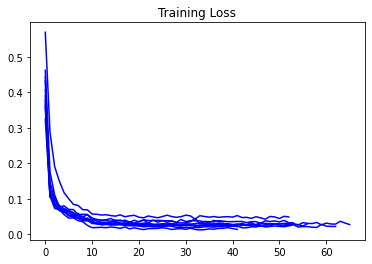

In [31]:
for i in range(len(histories)):
    plt.title('Training Loss')
    plt.plot(histories[i].history['loss'], color='blue')

plt.show()

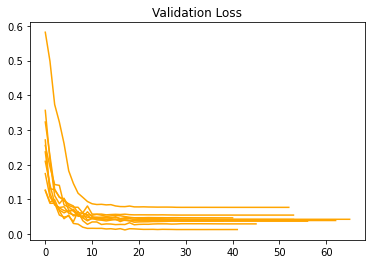

In [32]:
for i in range(len(histories)):
    plt.title('Validation Loss')
    plt.plot(histories[i].history['val_loss'], color='orange')
    
plt.show()

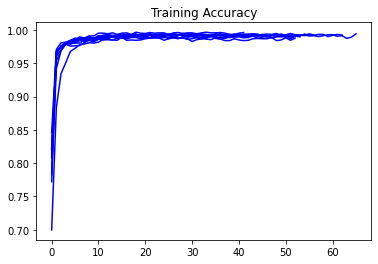

In [33]:
for i in range(len(histories)):
    plt.title('Training Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue')

plt.show()

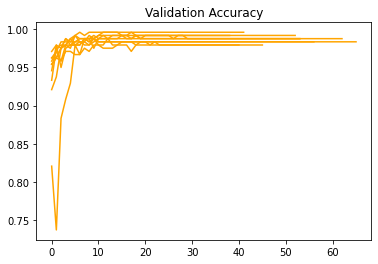

In [34]:
for i in range(len(histories)):
    plt.title('Validation Accuracy')
    plt.plot(histories[i].history['val_accuracy'], color='orange')

plt.show()

In [35]:
cv_train = np.mean(tr_acc), np.std(tr_acc)
cv_train

(0.9918775796890259, 0.002981810347942518)

In [36]:
cv_val = np.mean(val_acc), np.std(val_acc)
cv_val

(0.9866387724876404, 0.0051997501667297346)

In [37]:
cv_test = np.mean(ts_acc), np.std(ts_acc)
cv_test

(0.9849624037742615, 0.008063014090864205)

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

model = load_model(best_model_address)

y_blind = np.argmax(testY ,axis =  1)
x_blind = testX
blind_pred = np.argmax(model.predict(x_blind), axis =  1)

print("Calculating CLASSIFICATION REPORT: ")
labels = {'healthy': 0, 'covid': 1}
classification_report = classification_report(y_blind, blind_pred, target_names=labels)
print(classification_report)

print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
cm = confusion_matrix(y_blind, blind_pred)
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("sensitivity = {:.4f}".format(sensitivity))
print("specificity = {:.4f}".format(specificity))

Calculating CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

     healthy       0.87      1.00      0.93       133
       covid       1.00      0.85      0.92       133

    accuracy                           0.92       266
   macro avg       0.93      0.92      0.92       266
weighted avg       0.93      0.92      0.92       266


Calculating SENSITIVITY & SPECIFICITY..........:
sensitivity = 1.0000
specificity = 0.8496


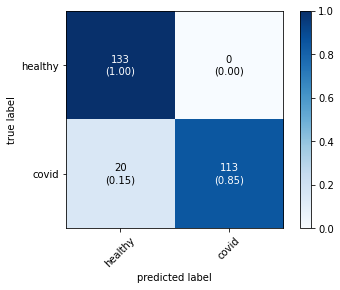

In [39]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                class_names=labels,
                                show_normed=True)

plt.savefig(os.path.join(char, 'cm.eps'))
plt.savefig(os.path.join(char, 'cm.jpg'))

plt.show()

In [40]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if y.shape[1] > 2:
    readme.write("This is a {}-class CLASSIFICATION".format(len(os.listdir(TRAINING_DIR))))
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(len(histories[0].history['loss'])))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
with redirect_stdout(readme):
    model.summary()


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\ntrain_acc = {} +- {}".format(cv_train[0], cv_train[1]))
readme.write("\nvalidation_acc = {} +- {}".format(cv_val[0], cv_val[1]))
readme.write("\ntest_acc = {} +- {}".format(cv_test[0], cv_test[1]))


readme.write("\n\n--Classification Report--\n")
readme.write(classification_report)

readme.write("\nSensitivity = " + str(int(sensitivity*100)) + " %")
readme.write("\nSpecificity = " + str(int(specificity*100)) + " %")


readme.write("\n\nCreated using Self-Regulated Classifier using Deep Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
